# 模型训练基础：nn.Module、损失函数与优化器

In [1]:
import torch
import torchvision
print(f"PyTorch版本: {torch.__version__}")
print(f"TorchVision版本: {torchvision.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA版本: {torch.version.cuda}")
    print(f"GPU名称: {torch.cuda.get_device_name(0)}")


PyTorch版本: 2.7.1+cu128
TorchVision版本: 0.22.1+cu128
CUDA可用: True
CUDA版本: 12.8
GPU名称: NVIDIA GeForce RTX 5060 Laptop GPU


## 1、nn.Module

In [ ]:
# Sequential模型(适合简单模型)
import torch
import torch.nn as nn
import torch.utils.tensorboard as tensorboard
model =nn.Sequential(
    nn.Linear(784,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10)
)
print(model)
x = torch.randn(32,784) #模拟一个batch输入
output =model(x)
print(x.shape)
print(output.shape)
Writer = tensorboard.SummaryWriter("./logs_sequential")
Writer.add_graph(model, x)
Writer.close()
##终端运行 tensorboard --logdir="D:\深度学习\daily learning(go go go)\logs_sequential" --port=6007

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([32, 784])
torch.Size([32, 10])


In [3]:
# 自定义模型(适合复杂模型)
class SimpleModel(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(SimpleModel, self).__init__() # 调用父类的init方法
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
model = SimpleModel(input_size=784,hidden_size =128,num_classes=10)
print(model)
x = torch.randn(32,784) 
output =model(x)
print(x.shape)
print(output.shape)

SimpleModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
)
torch.Size([32, 784])
torch.Size([32, 128])


In [4]:
# ModuleList & ModuleDict（动态网络）
class DynamicNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size,hidden_size[0])) #输入层
        for i in range(len(hidden_size)-1):
            self.layers.append(nn.Linear(hidden_size[i],hidden_size[i+1])) #隐藏层
        self.layers.append(nn.Linear(hidden_size[-1],num_classes)) #输出层
        self.relu = nn.ReLU()
    def forward(self,x):
        for i ,layer in enumerate(self.layers):
            x = self.relu(layer(x))
            x = self.layers[-1](x) #输出层不加激活函数
        return x
model_shallow = DynamicNet(784,[128],10)
model_deep = DynamicNet(784,[512,256,128],10)
print(model_shallow)
print(model_deep)

DynamicNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=10, bias=True)
  )
  (relu): ReLU()
)
DynamicNet(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (relu): ReLU()
)


In [ ]:
# 现代MLP模型（包含BN、Dropout）
class ModernMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.5):
        super().__init__()
        
        layers = []
        in_size = input_size
        
        # 构建隐藏层
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(in_size, hidden_size),
                nn.BatchNorm1d(hidden_size),  # BN
                nn.ReLU(),                     # 激活
                nn.Dropout(dropout_rate)       # Dropout
            ])
            in_size = hidden_size
        
        # 输出层（不加激活）
        layers.append(nn.Linear(in_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# 创建模型
model = ModernMLP(
    input_size=784,
    hidden_sizes=[512, 256, 128],
    num_classes=10,
    dropout_rate=0.3
)

print(model)
print(f"\n总参数量: {sum(p.numel() for p in model.parameters()):,}")

# 测试
x = torch.randn(32, 784)
model.eval()
with torch.no_grad():
    output = model(x)
print(f"\n输入: {x.shape} -> 输出: {output.shape}")


ModernMLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)

总参数量: 569,226

输入: torch.Size([32, 784]) -> 输出: torch.Size([32, 10])


### CIFAR 10 model 网络模型
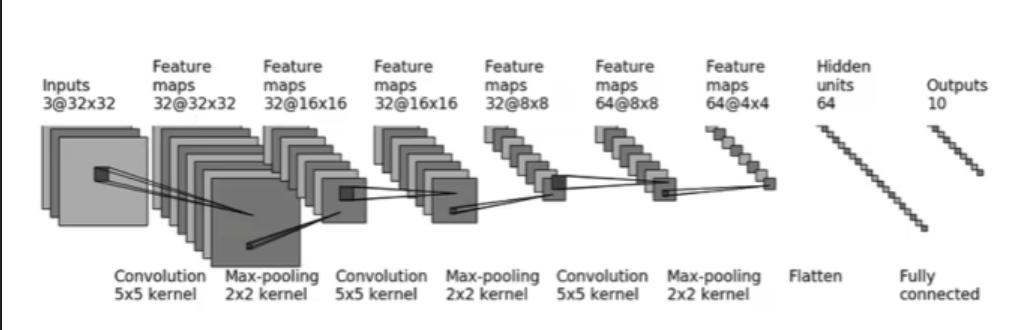

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Sequential,Conv2d, MaxPool2d, Flatten, Linear
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# 定义网络结构
class CIFAR (nn.Module):
    def __init__(self):
        super(CIFAR,self).__init__()
        self.model1 = Sequential(
            Conv2d(3,32,5,padding=2),
            MaxPool2d(2),
            Conv2d(32,32,5,padding=2),
            MaxPool2d(2),
            Conv2d(32,64,5,padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024,64),
            Linear(64,10))

        # super(CIFAR, self).__init__()
        # self.conv1 = Conv2d(3,32,5,padding=2)
        # self.maxpool1 = MaxPool2d(2)
        # self.conv2 = Conv2d(32,32,5,padding=2)
        # self.maxpool2 = MaxPool2d(2)
        # self.conv3 = Conv2d(32,64,5,padding=2)
        # self.maxpool3 = MaxPool2d(2)
        # self.flatten = Flatten()
        # self.linear1 = Linear(1024,64)
        # self.Linear2 = Linear(64,10)  
    
    def forward(self, x):
        x =self.model1(x)
        return x
        # x = self.conv1(x)
        # x = self.maxpool1(x)
        # x = self.conv2(x)
        # x = self.maxpool2(x)
        # x = self.conv3(x)
        # x = self.maxpool3(x)
        # x = self.flatten(x)
        # x = self.linear1(x)
        # x = self.Linear2(x)
        # return x

cifar = CIFAR()
print(cifar)
#显示网络
dataset = torchvision.datasets.CIFAR10(root='./data',train=False,transform=torchvision.transforms.ToTensor(),download=True)       
dataloader = DataLoader(dataset, batch_size=64,drop_last=True)
cifar = CIFAR()
writer = SummaryWriter("./logs_cifar")

cifar = CIFAR()
input = torch.ones((64,3,32,32))
output = cifar(input)
print(output.shape)

writer.add_graph(cifar, input)
writer.close()
# 查看网络结构 tensorboard --logdir="D:\深度学习\daily learning(go go go)\logs_cifar" --port=6007

CIFAR(
  (model1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1024, out_features=64, bias=True)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)
torch.Size([64, 10])


In [9]:
# 激活函数大全

x = torch.linspace(-3, 3, 100)
x_batch = torch.randn(32, 128)  # 用于计时测试

# 1. ReLU（最常用）
relu = nn.ReLU()
print("\n ReLU (Rectified Linear Unit)")
print("   公式: f(x) = max(0, x)")
print("   优点:  计算简单  缓解梯度消失  稀疏激活")
print("   缺点:  Dead ReLU问题（神经元死亡）")
print(f"   示例: ReLU(-1) = {relu(torch.tensor(-1.0)).item()}")
print(f"        ReLU(1)  = {relu(torch.tensor(1.0)).item()}")

# ==================== 2. LeakyReLU ====================
leaky_relu = nn.LeakyReLU(negative_slope=0.01)
print("\n LeakyReLU")
print("   公式: f(x) = max(0.01x, x)")
print("   优点:  解决Dead ReLU问题")
print("   缺点: 需要调参negative_slope")
print(f"   示例: LeakyReLU(-1) = {leaky_relu(torch.tensor(-1.0)).item():.4f}")
print(f"        LeakyReLU(1)  = {leaky_relu(torch.tensor(1.0)).item():.4f}")

#  3. PReLU 
prelu = nn.PReLU()  # 参数化ReLU，negative_slope可学习
print("\n PReLU (Parametric ReLU)")
print("   公式: f(x) = max(αx, x)  其中α是可学习参数")
print("   优点:  自动学习最佳negative_slope")
print(f"   当前α值: {prelu.weight.item():.4f}")

#  4. ELU
elu = nn.ELU(alpha=1.0)
print("\n ELU (Exponential Linear Unit)")
print("   公式: f(x) = x if x>0 else α(exp(x)-1)")
print("   优点:  输出均值接近0  缓解梯度消失")
print("   缺点:  计算exp较慢")
print(f"   示例: ELU(-1) = {elu(torch.tensor(-1.0)).item():.4f}")
print(f"        ELU(1)  = {elu(torch.tensor(1.0)).item():.4f}")

#  5. GELU（Transformer常用）
gelu = nn.GELU()
print("\n GELU (Gaussian Error Linear Unit)")
print("   公式: f(x) = x * Φ(x)  其中Φ是标准正态分布CDF")
print("   优点:  BERT/GPT等模型默认激活 平滑函数")
print(f"   示例: GELU(-1) = {gelu(torch.tensor(-1.0)).item():.4f}")
print(f"        GELU(1)  = {gelu(torch.tensor(1.0)).item():.4f}")

# 6. Sigmoid 
sigmoid = nn.Sigmoid()
print("\n Sigmoid")
print("   公式: f(x) = 1 / (1 + exp(-x))")
print("   应用: 二分类输出层")
print("   缺点:  梯度消失严重  输出非零中心")
print(f"   示例: Sigmoid(-2) = {sigmoid(torch.tensor(-2.0)).item():.4f}")
print(f"        Sigmoid(0)  = {sigmoid(torch.tensor(0.0)).item():.4f}")
print(f"        Sigmoid(2)  = {sigmoid(torch.tensor(2.0)).item():.4f}")

#  7. Tanh
tanh = nn.Tanh()
print("\n Tanh")
print("   公式: f(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))")
print("   优点:  零中心输出 [-1, 1]")
print("   缺点:  梯度消失问题")
print(f"   示例: Tanh(-2) = {tanh(torch.tensor(-2.0)).item():.4f}")
print(f"        Tanh(0)  = {tanh(torch.tensor(0.0)).item():.4f}")
print(f"        Tanh(2)  = {tanh(torch.tensor(2.0)).item():.4f}")

#  8. Softmax 
softmax = nn.Softmax(dim=1)
print("\n Softmax")
print("   公式: f(x_i) = exp(x_i) / Σexp(x_j)")
print("   应用:  多分类输出层")
print("   特性:  输出和为1  概率解释")
x_softmax = torch.tensor([[1.0, 2.0, 3.0]])
out_softmax = softmax(x_softmax)
print(f"   示例: Softmax([1,2,3]) = {out_softmax.squeeze().tolist()}")
print(f"        输出和: {out_softmax.sum().item():.6f}")

#  9. Swish/SiL
silu = nn.SiLU()  # Swish激活函数
print("\n SiLU/Swish")
print("   公式: f(x) = x * sigmoid(x)")
print("   优点:  性能优于ReLU  平滑可微")
print(f"   示例: SiLU(-1) = {silu(torch.tensor(-1.0)).item():.4f}")
print(f"        SiLU(1)  = {silu(torch.tensor(1.0)).item():.4f}")

#  10. Mish
mish = nn.Mish()
print("\n Mish")
print("   公式: f(x) = x * tanh(softplus(x))")
print("   优点: 平滑  非单调  无上界")
print(f"   示例: Mish(-1) = {mish(torch.tensor(-1.0)).item():.4f}")
print(f"        Mish(1)  = {mish(torch.tensor(1.0)).item():.4f}")

print("\n" + "=" * 80)



 ReLU (Rectified Linear Unit)
   公式: f(x) = max(0, x)
   优点:  计算简单  缓解梯度消失  稀疏激活
   缺点:  Dead ReLU问题（神经元死亡）
   示例: ReLU(-1) = 0.0
        ReLU(1)  = 1.0

 LeakyReLU
   公式: f(x) = max(0.01x, x)
   优点:  解决Dead ReLU问题
   缺点: 需要调参negative_slope
   示例: LeakyReLU(-1) = -0.0100
        LeakyReLU(1)  = 1.0000

 PReLU (Parametric ReLU)
   公式: f(x) = max(αx, x)  其中α是可学习参数
   优点:  自动学习最佳negative_slope
   当前α值: 0.2500

 ELU (Exponential Linear Unit)
   公式: f(x) = x if x>0 else α(exp(x)-1)
   优点:  输出均值接近0  缓解梯度消失
   缺点:  计算exp较慢
   示例: ELU(-1) = -0.6321
        ELU(1)  = 1.0000

 GELU (Gaussian Error Linear Unit)
   公式: f(x) = x * Φ(x)  其中Φ是标准正态分布CDF
   优点:  BERT/GPT等模型默认激活 平滑函数
   示例: GELU(-1) = -0.1587
        GELU(1)  = 0.8413

 Sigmoid
   公式: f(x) = 1 / (1 + exp(-x))
   应用: 二分类输出层
   缺点:  梯度消失严重  输出非零中心
   示例: Sigmoid(-2) = 0.1192
        Sigmoid(0)  = 0.5000
        Sigmoid(2)  = 0.8808

 Tanh
   公式: f(x) = (exp(x) - exp(-x)) / (exp(x) + exp(-x))
   优点:  零中心输出 [-1, 1]
   缺点:  梯度消失问题
   示例: Ta

## 2、损失函数（Loss Function）

In [11]:
# CrossEntropyloss -muti-class classification
import torch
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
# 模拟输出：logits（未经softmax，原始分数）
batch_size = 4
num_classes = 3
logits = torch.randn(batch_size, num_classes)  
targets = torch.tensor([0, 1, 2, 1])  # 真实标签（类别索引）

print(f"\nLogits (模型原始输出):")
print(logits)
print(f"\nTargets (真实标签): {targets}")

loss = criterion(logits, targets)
print(f"\nCrossEntropyLoss: {loss.item():.4f}")

# 手动实现CrossEntropyLoss
def manual_cross_entropy(logits, targets):
    """手动实现交叉熵"""
    # 步骤1：Softmax
    probs = F.softmax(logits, dim=1)
    print(f"Softmax概率分布:")
    print(probs)
    
    # 步骤2：取对数
    log_probs = torch.log(probs)
    
    # 步骤3：选择正确类别的log概率
    n = logits.size(0)
    log_likelihood = log_probs[range(n), targets]
    
    # 步骤4：取负平均
    loss = -log_likelihood.mean()
    return loss, probs

manual_loss, probs = manual_cross_entropy(logits, targets)
print(f"\n手动计算的loss: {manual_loss.item():.4f}")
print(f"PyTorch的loss: {loss.item():.4f}")
print(f"误差: {abs(manual_loss.item() - loss.item()):.8f}")



Logits (模型原始输出):
tensor([[ 1.5099,  0.7327,  0.7224],
        [ 1.2859, -1.1467, -0.0085],
        [ 0.7177,  0.3216,  0.5398],
        [-0.7783,  2.0164,  1.3440]])

Targets (真实标签): tensor([0, 1, 2, 1])

CrossEntropyLoss: 1.2353
Softmax概率分布:
tensor([[0.5223, 0.2401, 0.2376],
        [0.7343, 0.0645, 0.2012],
        [0.3984, 0.2681, 0.3335],
        [0.0389, 0.6363, 0.3248]])

手动计算的loss: 1.2353
PyTorch的loss: 1.2353
误差: 0.00000000


In [15]:
# BCELoss vs BCEWithLogitsLoss -binary classification
import torch 
import torch.nn as nn
#  BCELoss：需要手动sigmoid 
print("\n BCELoss (Binary Cross Entropy)")
criterion_bce = nn.BCELoss()

# 需要先经过sigmoid
logits = torch.randn(4, 1)
probs = torch.sigmoid(logits)  # 必须先sigmoid
targets = torch.tensor([[1.], [0.], [1.], [0.]])

loss = criterion_bce(probs, targets)
print(f"   BCELoss: {loss.item():.4f}")

# BCEWithLogitsLoss：推荐使用
print("\n BCEWithLogitsLoss (推荐！)")
criterion_bce_logits = nn.BCEWithLogitsLoss()

# 直接使用logits
logits = torch.randn(4, 1)
targets = torch.tensor([[1.], [0.], [1.], [0.]])

loss = criterion_bce_logits(logits, targets)
print(f"   BCEWithLogitsLoss: {loss.item():.4f}")


 BCELoss (Binary Cross Entropy)
   BCELoss: 1.0428

 BCEWithLogitsLoss (推荐！)
   BCEWithLogitsLoss: 0.6934


In [ ]:
# another classification loss
##  1. NLLLoss 
print("\n NLLLoss (Negative Log Likelihood)")
criterion_nll = nn.NLLLoss()

logits = torch.randn(4, 3)
log_probs = F.log_softmax(logits, dim=1)  
targets = torch.tensor([0, 1, 2, 1])

loss = criterion_nll(log_probs, targets)
print(f"   NLLLoss: {loss.item():.4f}")
print("   NLLLoss + LogSoftmax = CrossEntropyLoss")

##  2. MultiMarginLoss 
print("\n MultiMarginLoss (多类别间隔损失)")
criterion_mm = nn.MultiMarginLoss()

logits = torch.randn(4, 3)
targets = torch.tensor([0, 1, 2, 1])

loss = criterion_mm(logits, targets)
print(f"   MultiMarginLoss: {loss.item():.4f}")
print("    SVM风格的损失，适合间隔最大化")

## 3. KLDivLoss 
print("\n KLDivLoss (KL散度，用于知识蒸馏)")
criterion_kl = nn.KLDivLoss(reduction='batchmean')

# 学生模型输出
student_logits = torch.randn(4, 3)
student_log_probs = F.log_softmax(student_logits, dim=1)

# 教师模型输出（软标签）
teacher_logits = torch.randn(4, 3)
teacher_probs = F.softmax(teacher_logits / 2.0, dim=1)  # 温度系数=2

loss = criterion_kl(student_log_probs, teacher_probs)
print(f"   KLDivLoss: {loss.item():.4f}")
print("    知识蒸馏的核心损失")



 NLLLoss (Negative Log Likelihood)
   NLLLoss: 2.3252
   💡 NLLLoss + LogSoftmax = CrossEntropyLoss

 MultiMarginLoss (多类别间隔损失)
   MultiMarginLoss: 1.0818
   💡 SVM风格的损失，适合间隔最大化

 KLDivLoss (KL散度，用于知识蒸馏)
   KLDivLoss: 0.1276
   💡 知识蒸馏的核心损失


In [17]:
## Regression Losses
## 1. MSE（均方误差） 
criterion_mse = nn.MSELoss()

predictions = torch.tensor([1.5, 2.3, 3.8, 4.1])
targets = torch.tensor([1.0, 2.0, 4.0, 4.5])

loss_mse = criterion_mse(predictions, targets)
print(f"MSE Loss: {loss_mse.item():.4f}")

## 2. MAE（平均绝对误差） 
criterion_mae = nn.L1Loss()
loss_mae = criterion_mae(predictions, targets)
print(f"MAE Loss: {loss_mae.item():.4f}")

## 3. Smooth L1 Loss 
# 结合了L1和L2的优点，对离群点不敏感
criterion_smooth = nn.SmoothL1Loss()
loss_smooth = criterion_smooth(predictions, targets)
print(f"Smooth L1 Loss: {loss_smooth.item():.4f}")

## 4. Huber Loss（自定义）
class HuberLoss(nn.Module):
    """Huber Loss：delta内用L2，外用L1"""
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta
    
    def forward(self, pred, target):
        abs_error = torch.abs(pred - target)
        quadratic = torch.where(abs_error <= self.delta,
                                0.5 * abs_error ** 2,
                                self.delta * (abs_error - 0.5 * self.delta))
        return quadratic.mean()

huber_criterion = HuberLoss(delta=1.0)
loss_huber = huber_criterion(predictions, targets)
print(f"Huber Loss: {loss_huber.item():.4f}")


MSE Loss: 0.1350
MAE Loss: 0.3500
Smooth L1 Loss: 0.0675
Huber Loss: 0.0675


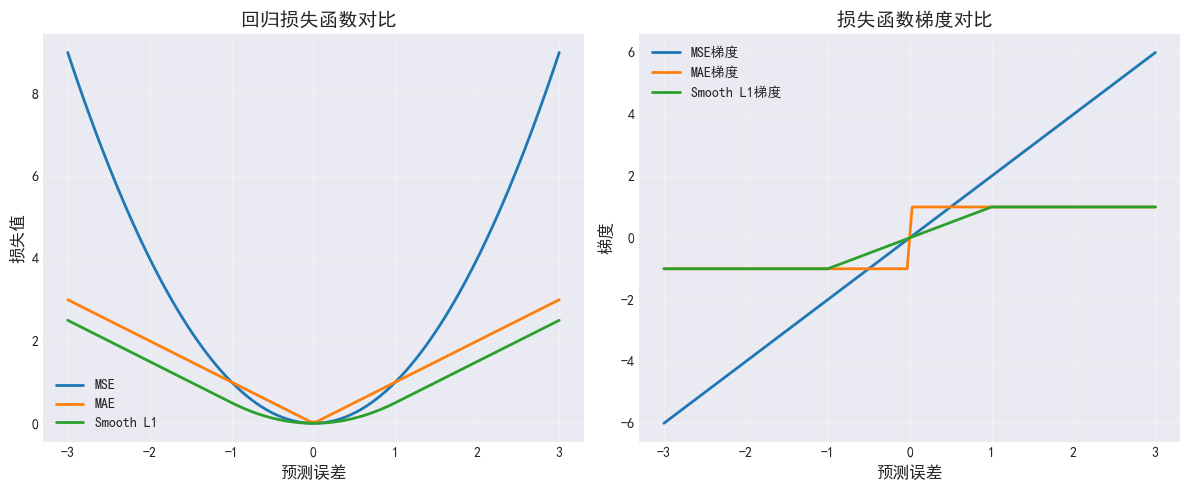

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 对比不同损失函数 
errors = np.linspace(-3, 3, 100)
mse = errors ** 2
mae = np.abs(errors)
smooth_l1 = np.where(np.abs(errors) < 1, 
                     0.5 * errors ** 2,
                     np.abs(errors) - 0.5)
huber = np.where(np.abs(errors) < 1,
                 0.5 * errors ** 2,
                 np.abs(errors) - 0.5)

plt.figure(figsize=(12, 5))

# 子图1：损失函数对比
plt.subplot(1, 2, 1)
plt.plot(errors, mse, label='MSE', linewidth=2)
plt.plot(errors, mae, label='MAE', linewidth=2)
plt.plot(errors, smooth_l1, label='Smooth L1', linewidth=2)
plt.xlabel('预测误差', fontsize=12)
plt.ylabel('损失值', fontsize=12)
plt.title(' 回归损失函数对比', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：梯度对比
plt.subplot(1, 2, 2)
mse_grad = 2 * errors
mae_grad = np.sign(errors)
smooth_grad = np.where(np.abs(errors) < 1, errors, np.sign(errors))

plt.plot(errors, mse_grad, label='MSE梯度', linewidth=2)
plt.plot(errors, mae_grad, label='MAE梯度', linewidth=2)
plt.plot(errors, smooth_grad, label='Smooth L1梯度', linewidth=2)
plt.xlabel('预测误差', fontsize=12)
plt.ylabel('梯度', fontsize=12)
plt.title(' 损失函数梯度对比', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 3、 优化器（Optimizer）

In [24]:
import torch.optim as optim

# 创建模型和参数
model = nn.Linear(10, 1)

# 1. SGD（随机梯度下降）
optimizer_sgd = optim.SGD(
    model.parameters(),
    lr=0.01,              # 学习率
    momentum=0.9,         # 动量
    weight_decay=1e-4,    # L2正则化
    nesterov=True         # Nesterov动量
)

# 2. Adam（自适应学习率）
optimizer_adam = optim.Adam(
    model.parameters(),
    lr=0.001,             # 学习率（通常比SGD小）
    betas=(0.9, 0.999),   # 一阶和二阶动量系数
    eps=1e-8,             # 数值稳定性
    weight_decay=1e-4     # L2正则化
)

# 3. AdamW（修正版Adam）
optimizer_adamw = optim.AdamW(
    model.parameters(),
    lr=0.001,
    betas=(0.9, 0.999),
    weight_decay=0.01     # 权重衰减（不同于L2正则）
)

# 4. RMSprop
optimizer_rmsprop = optim.RMSprop(
    model.parameters(),
    lr=0.01,
    alpha=0.99,           # 平滑常数
    momentum=0.0,
    weight_decay=0
)

# 5. Adagrad
optimizer_adagrad = optim.Adagrad(
    model.parameters(),
    lr=0.01,
    weight_decay=0
)



In [ ]:
# 神经网路优化数轮
import torch
import torchvision
from torch import nn 
from torch.nn import Conv2d, MaxPool2d, Flatten, Linear, Sequential
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

dataset = torchvision.datasets.CIFAR10("./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)       
dataloader = DataLoader(dataset, batch_size=64,drop_last=True)

class Fei(nn.Module):
    def __init__(self):
        super(Fei, self).__init__()        
        self.model1 = Sequential(
            Conv2d(3,32,5,padding=2),
            MaxPool2d(2),
            Conv2d(32,32,5,padding=2),
            MaxPool2d(2),
            Conv2d(32,64,5,padding=2),
            MaxPool2d(2),
            Flatten(),
            Linear(1024,64),
            Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x
    
loss = nn.CrossEntropyLoss() # 交叉熵    
fei = Fei()
optim = torch.optim.SGD(fei.parameters(),lr=0.01)   # 随机梯度下降优化器
for epoch in range(50):
    running_loss = 0.0
    for data in dataloader:
        imgs, targets = data
        outputs = fei(imgs)
        result_loss = loss(outputs, targets) # 计算实际输出与目标输出的差距
        optim.zero_grad()  # 梯度清零
        result_loss.backward() # 反向传播，计算损失函数的梯度
        optim.step()   # 根据梯度，对网络的参数进行调优
        running_loss = running_loss + result_loss
    print(running_loss) # 对这一轮所有误差的总和

tensor(358.5780, grad_fn=<AddBackward0>)
tensor(355.3977, grad_fn=<AddBackward0>)
tensor(343.0563, grad_fn=<AddBackward0>)
tensor(321.8235, grad_fn=<AddBackward0>)
tensor(313.4209, grad_fn=<AddBackward0>)
tensor(307.9497, grad_fn=<AddBackward0>)
tensor(301.7318, grad_fn=<AddBackward0>)
tensor(293.2397, grad_fn=<AddBackward0>)
tensor(285.2209, grad_fn=<AddBackward0>)
tensor(277.4458, grad_fn=<AddBackward0>)
tensor(269.9442, grad_fn=<AddBackward0>)
tensor(263.3866, grad_fn=<AddBackward0>)
tensor(257.5727, grad_fn=<AddBackward0>)
tensor(252.2037, grad_fn=<AddBackward0>)
tensor(247.2053, grad_fn=<AddBackward0>)
tensor(242.5943, grad_fn=<AddBackward0>)
tensor(238.3664, grad_fn=<AddBackward0>)
tensor(234.4760, grad_fn=<AddBackward0>)
tensor(230.8470, grad_fn=<AddBackward0>)
tensor(227.3968, grad_fn=<AddBackward0>)



## 4、标准训练过程：
### 1）、设置模型为训练模式 model。train
### 2）、遍历数据批次  for data ,target in train_loader
### 3）、数据转移到设备 data.to(device)   gpu训练主要有三部分：网络模型、数据(输入、标注)、损失函数
### 4）、清零梯度 optimizer.zero_grad()
### 5）、前向传播 output = model(data)
### 6）、计算损失 loss = loss_fn(output,target)
### 7）、反向传播 loss.backward()
### 8）、优化器更新参数 optimizer.step()
### 9）、设置模型为评估模式 model.eval()
### 10）、评估模型性能
### 11）、保存模型

In [3]:
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

# from model import * 相当于把 model中的所有内容写到这里，这里直接把 model 写在这里
class FEI(nn.Module):
    def __init__(self):
        super(FEI, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),  # 输入通道3，输出通道32，卷积核尺寸5×5，步长1，填充2    
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 展平后变成 64*4*4 了
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

# 准备数据集
train_data = torchvision.datasets.CIFAR10("./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)       
test_data = torchvision.datasets.CIFAR10("./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)       

# length 长度
train_data_size = len(train_data)
test_data_size = len(test_data)
# 如果train_data_size=10，则打印：训练数据集的长度为：10
print("训练数据集的长度：{}".format(train_data_size))
print("测试数据集的长度：{}".format(test_data_size))

# 利用 Dataloader 来加载数据集
train_dataloader = DataLoader(train_data, batch_size=64)        
test_dataloader = DataLoader(test_data, batch_size=64)

# 创建网络模型
fei = FEI() 

# 损失函数
loss_fn = nn.CrossEntropyLoss() # 交叉熵，fn 是 fuction 的缩写

# 优化器
learning = 0.01  # 1e-2 就是 0.01 的意思
optimizer = torch.optim.SGD(fei.parameters(),learning)   # 随机梯度下降优化器  

# 设置网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0

# 训练的轮次
epoch = 10

# 添加 tensorboard
writer = SummaryWriter("logs")
start_time = time.time()

for i in range(epoch):
    print("-----第 {} 轮训练开始-----".format(i+1))
    
    # 训练步骤开始
    fei.train() # 当网络中有dropout层、batchnorm层时，这些层能起作用
    for data in train_dataloader:
        imgs, targets = data
        outputs = fei(imgs)
        loss = loss_fn(outputs, targets) # 计算实际输出与目标输出的差距
        
        # 优化器对模型调优
        optimizer.zero_grad()  # 梯度清零
        loss.backward() # 反向传播，计算损失函数的梯度
        optimizer.step()   # 根据梯度，对网络的参数进行调优
        
        total_train_step = total_train_step + 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time) # 运行训练一百次后的时间间隔
            print("训练次数：{}，Loss：{}".format(total_train_step,loss.item()))  # 方式二：获得loss值
            writer.add_scalar("train_loss",loss.item(),total_train_step)
    
    # 测试步骤开始（每一轮训练后都查看在测试数据集上的loss情况）
    fei.eval()  # 当网络中有dropout层、batchnorm层时，这些层不能起作用
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():  # 没有梯度了
        for data in test_dataloader: # 测试数据集提取数据
            imgs, targets = data 
            outputs = fei(imgs)
            loss = loss_fn(outputs, targets) # 仅data数据在网络模型上的损失
            total_test_loss = total_test_loss + loss.item() # 所有loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy
            
    print("整体测试集上的Loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss",total_test_loss,total_test_step)
    writer.add_scalar("test_accuracy",total_accuracy/test_data_size,total_test_step)  
    total_test_step = total_test_step + 1
    
    torch.save(fei, "./model/fei_{}.pth".format(i)) # 保存每一轮训练后的结果
    #torch.save(fei.state_dict(),"fei_{}.path".format(i)) # 保存方式二         
    print("模型已保存")
    
writer.close()

训练数据集的长度：50000
测试数据集的长度：10000
-----第 1 轮训练开始-----
1.9863648414611816
训练次数：100，Loss：2.2919702529907227
3.882399559020996
训练次数：200，Loss：2.2842907905578613
5.869009733200073
训练次数：300，Loss：2.255920171737671
7.841384649276733
训练次数：400，Loss：2.19985294342041
9.89371395111084
训练次数：500，Loss：2.07757306098938
12.449255466461182
训练次数：600，Loss：2.027271032333374
14.59339690208435
训练次数：700，Loss：1.9911291599273682
整体测试集上的Loss：312.10566449165344
整体测试集上的正确率：0.2840000092983246
模型已保存
-----第 2 轮训练开始-----
18.82293701171875
训练次数：800，Loss：1.8560378551483154
20.991289377212524
训练次数：900，Loss：1.8223321437835693
23.084915161132812
训练次数：1000，Loss：1.869386076927185
25.171340703964233
训练次数：1100，Loss：2.016090154647827
27.324143171310425
训练次数：1200，Loss：1.6755642890930176
29.457425355911255
训练次数：1300，Loss：1.6300487518310547
31.5560302734375
训练次数：1400，Loss：1.7060105800628662
33.70454239845276
训练次数：1500，Loss：1.749072551727295
整体测试集上的Loss：291.2265020608902
整体测试集上的正确率：0.3303999900817871
模型已保存
-----第 3 轮训练开始-----
37.8362269

In [1]:
# 利用GPU训练（方式1）
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

class FEI(nn.Module):
    def __init__(self):
        super(FEI, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),  # 输入通道3，输出通道32，卷积核尺寸5×5，步长1，填充2    
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 展平后变成 64*4*4 了
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

# 准备数据集
train_data = torchvision.datasets.CIFAR10("./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)       
test_data = torchvision.datasets.CIFAR10("./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)       

# length 长度
train_data_size = len(train_data)
test_data_size = len(test_data)
# 如果train_data_size=10，则打印：训练数据集的长度为：10
print("训练数据集的长度：{}".format(train_data_size))
print("测试数据集的长度：{}".format(test_data_size))

# 利用 Dataloader 来加载数据集
train_dataloader = DataLoader(train_data, batch_size=64)        
test_dataloader = DataLoader(test_data, batch_size=64)

# 创建网络模型
fei = FEI() 
if torch.cuda.is_available():
    fei = fei.cuda() # 网络模型转移到cuda上

# 损失函数
loss_fn = nn.CrossEntropyLoss() # 交叉熵，fn 是 fuction 的缩写
if torch.cuda.is_available():
    loss_fn = loss_fn.cuda()        # 损失函数转移到cuda上

# 优化器
learning = 0.01  # 1e-2 就是 0.01 的意思
optimizer = torch.optim.SGD(fei.parameters(),learning)   # 随机梯度下降优化器  

# 设置网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0

# 训练的轮次
epoch = 30

# 添加 tensorboard
writer = SummaryWriter("logs")

for i in range(epoch):
    print("-----第 {} 轮训练开始-----".format(i+1))
    
    # 训练步骤开始
    fei.train() # 当网络中有dropout层、batchnorm层时，这些层能起作用
    for data in train_dataloader:
        imgs, targets = data
        if torch.cuda.is_available():
            imgs = imgs.cuda()  # 数据放到cuda上
            targets = targets.cuda() # 数据放到cuda上
        outputs = fei(imgs)
        loss = loss_fn(outputs, targets) # 计算实际输出与目标输出的差距
        
        # 优化器对模型调优
        optimizer.zero_grad()  # 梯度清零
        loss.backward() # 反向传播，计算损失函数的梯度
        optimizer.step()   # 根据梯度，对网络的参数进行调优
        
        total_train_step = total_train_step + 1
        if total_train_step % 100 == 0:
            print("训练次数：{}，Loss：{}".format(total_train_step,loss.item()))  # 方式二：获得loss值
            writer.add_scalar("train_loss",loss.item(),total_train_step)
    
    # 测试步骤开始（每一轮训练后都查看在测试数据集上的loss情况）
    fei.eval()  # 当网络中有dropout层、batchnorm层时，这些层不能起作用
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():  # 没有梯度了
        for data in test_dataloader: # 测试数据集提取数据
            imgs, targets = data # 数据放到cuda上
            if torch.cuda.is_available():
                imgs = imgs.cuda() # 数据放到cuda上
                targets = targets.cuda()
            outputs = fei(imgs)
            loss = loss_fn(outputs, targets) # 仅data数据在网络模型上的损失
            total_test_loss = total_test_loss + loss.item() # 所有loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy
            
    print("整体测试集上的Loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss",total_test_loss,total_test_step)
    writer.add_scalar("test_accuracy",total_accuracy/test_data_size,total_test_step)  
    total_test_step = total_test_step + 1
    
    torch.save(fei, "./model/fei_{}.pth".format(i)) # 保存每一轮训练后的结果
    #torch.save(fei.state_dict(),"fei_{}.path".format(i)) # 保存方式二         
    print("模型已保存")
    
writer.close()

训练数据集的长度：50000
测试数据集的长度：10000
-----第 1 轮训练开始-----
训练次数：100，Loss：2.2887210845947266
训练次数：200，Loss：2.276925802230835
训练次数：300，Loss：2.235412120819092
训练次数：400，Loss：2.130870819091797
训练次数：500，Loss：2.050673723220825
训练次数：600，Loss：2.0115127563476562
训练次数：700，Loss：2.0255279541015625
整体测试集上的Loss：311.9846888780594
整体测试集上的正确率：0.28509998321533203
模型已保存
-----第 2 轮训练开始-----
训练次数：800，Loss：1.8599427938461304
训练次数：900，Loss：1.8259425163269043
训练次数：1000，Loss：1.8987584114074707
训练次数：1100，Loss：1.954670786857605
训练次数：1200，Loss：1.6993011236190796
训练次数：1300，Loss：1.664635181427002
训练次数：1400，Loss：1.7138464450836182
训练次数：1500，Loss：1.8140679597854614
整体测试集上的Loss：301.63456296920776
整体测试集上的正确率：0.31790000200271606
模型已保存
-----第 3 轮训练开始-----
训练次数：1600，Loss：1.7599512338638306
训练次数：1700，Loss：1.6251132488250732
训练次数：1800，Loss：1.9265426397323608
训练次数：1900，Loss：1.6714489459991455
训练次数：2000，Loss：1.9174423217773438
训练次数：2100，Loss：1.5127619504928589
训练次数：2200，Loss：1.4699392318725586
训练次数：2300，Loss：1.7931838035583496
整体测试集上的L

In [ ]:
# 利用GPU训练（方式2）
# 当电脑有多个 GPU 时，指定使用其中一个 GPU 进行训练
import torchvision
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time

# 定义训练的设备
#device = torch.device("cpu")
#device = torch.device("cuda")   # 使用 GPU 方式一 
#device = torch.device("cuda:0") # 使用 GPU 方式二
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from model import * 相当于把 model中的所有内容写到这里，这里直接把 model 写在这里
class FEI(nn.Module):
    def __init__(self):
        super(FEI, self).__init__()        
        self.model1 = nn.Sequential(
            nn.Conv2d(3,32,5,1,2),  # 输入通道3，输出通道32，卷积核尺寸5×5，步长1，填充2    
            nn.MaxPool2d(2),
            nn.Conv2d(32,32,5,1,2),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,5,1,2),
            nn.MaxPool2d(2),
            nn.Flatten(),  # 展平后变成 64*4*4 了
            nn.Linear(64*4*4,64),
            nn.Linear(64,10)
        )
        
    def forward(self, x):
        x = self.model1(x)
        return x

# 准备数据集
train_data = torchvision.datasets.CIFAR10("./data",train=True,transform=torchvision.transforms.ToTensor(),download=True)       
test_data = torchvision.datasets.CIFAR10("./data",train=False,transform=torchvision.transforms.ToTensor(),download=True)       

# length 长度
train_data_size = len(train_data)
test_data_size = len(test_data)
# 如果train_data_size=10，则打印：训练数据集的长度为：10
print("训练数据集的长度：{}".format(train_data_size))
print("测试数据集的长度：{}".format(test_data_size))

# 利用 Dataloader 来加载数据集
train_dataloader = DataLoader(train_data, batch_size=64)        
test_dataloader = DataLoader(test_data, batch_size=64)

# 创建网络模型
fei = FEI() 
fei = fei.to(device) # 也可以不赋值，直接 fei.to(device) 


# 损失函数
loss_fn = nn.CrossEntropyLoss() # 交叉熵，fn 是 fuction 的缩写
loss_fn = loss_fn.to(device) # 也可以不赋值，直接loss_fn.to(device)

# 优化器
learning = 0.01  # 1e-2 就是 0.01 的意思
optimizer = torch.optim.SGD(fei.parameters(),learning)   # 随机梯度下降优化器  

# 设置网络的一些参数
# 记录训练的次数
total_train_step = 0
# 记录测试的次数
total_test_step = 0

# 训练的轮次
epoch = 30

# 添加 tensorboard
writer = SummaryWriter("logs")
start_time = time.time()

for i in range(epoch):
    print("-----第 {} 轮训练开始-----".format(i+1))
    
    # 训练步骤开始
    fei.train() # 当网络中有dropout层、batchnorm层时，这些层能起作用
    for data in train_dataloader:
        imgs, targets = data            
        imgs = imgs.to(device) # 也可以不赋值，直接 imgs.to(device)
        targets = targets.to(device) # 也可以不赋值，直接 targets.to(device)
        outputs = fei(imgs)
        loss = loss_fn(outputs, targets) # 计算实际输出与目标输出的差距
        
        # 优化器对模型调优
        optimizer.zero_grad()  # 梯度清零
        loss.backward() # 反向传播，计算损失函数的梯度
        optimizer.step()   # 根据梯度，对网络的参数进行调优
        
        total_train_step = total_train_step + 1
        if total_train_step % 100 == 0:
            end_time = time.time()
            print(end_time - start_time) # 运行训练一百次后的时间间隔
            print("训练次数：{}，Loss：{}".format(total_train_step,loss.item()))  # 方式二：获得loss值
            writer.add_scalar("train_loss",loss.item(),total_train_step)
    
    # 测试步骤开始（每一轮训练后都查看在测试数据集上的loss情况）
    fei.eval()  # 当网络中有dropout层、batchnorm层时，这些层不能起作用
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():  # 没有梯度了
        for data in test_dataloader: # 测试数据集提取数据
            imgs, targets = data # 数据放到cuda上
            imgs = imgs.to(device) # 也可以不赋值，直接 imgs.to(device)
            targets = targets.to(device) # 也可以不赋值，直接 targets.to(device)
            outputs = fei(imgs)
            loss = loss_fn(outputs, targets) # 仅data数据在网络模型上的损失
            total_test_loss = total_test_loss + loss.item() # 所有loss
            accuracy = (outputs.argmax(1) == targets).sum()
            total_accuracy = total_accuracy + accuracy
            
    print("整体测试集上的Loss：{}".format(total_test_loss))
    print("整体测试集上的正确率：{}".format(total_accuracy/test_data_size))
    writer.add_scalar("test_loss",total_test_loss,total_test_step)
    writer.add_scalar("test_accuracy",total_accuracy/test_data_size,total_test_step)  
    total_test_step = total_test_step + 1

    torch.save(fei, "./model/fei_{}.pth".format(i)) # 保存每一轮训练后的结果
    #torch.save(fei.state_dict(),"fei_{}.path".format(i)) # 保存方式二         
    print("模型已保存")
    
writer.close()

## 5、实战（手写数字分类）

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

#  1. 准备数据 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)


In [5]:
#2. 定义模型 
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [6]:
# 3. 初始化
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"设备: {device}")
print(f"模型参数量: {sum(p.numel() for p in model.parameters()):,}")


设备: cuda
模型参数量: 537,354


In [7]:
# 4. 训练函数 
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='训练')
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 统计
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # 更新进度条
        pbar.set_postfix({
            'loss': f'{running_loss/len(dataloader):.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss / len(dataloader), 100. * correct / total

In [8]:

# 5. 验证函数 
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='验证')
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            running_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            pbar.set_postfix({
                'loss': f'{running_loss/len(dataloader):.4f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    return running_loss / len(dataloader), 100. * correct / total


In [9]:

#  6. 训练循环
num_epochs = 10
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_acc = 0.0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # 训练
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # 学习率调度
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # 打印总结
    print(f"\n训练 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"验证 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"学习率: {current_lr:.6f}")
    
    # 保存最佳模型
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc,
        }, 'best_model.pth')
        print(f"✅ 保存最佳模型! Acc: {best_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
    
    # 早停
    if patience_counter >= patience:
        print(f"\n {patience}个epoch未改善，早停！")
        break

print(f"\n训练完成! 最佳验证准确率: {best_acc:.2f}%")



Epoch 1/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:44<00:00,  1.76it/s, loss=0.0995, acc=96.95%]



训练 - Loss: 0.2199, Acc: 93.62%
验证 - Loss: 0.0995, Acc: 96.95%
学习率: 0.001000
✅ 保存最佳模型! Acc: 96.95%

Epoch 2/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.75it/s, loss=0.0779, acc=97.62%]



训练 - Loss: 0.0989, Acc: 96.95%
验证 - Loss: 0.0779, Acc: 97.62%
学习率: 0.001000
✅ 保存最佳模型! Acc: 97.62%

Epoch 3/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.75it/s, loss=0.0642, acc=97.82%]



训练 - Loss: 0.0728, Acc: 97.72%
验证 - Loss: 0.0642, Acc: 97.82%
学习率: 0.001000
✅ 保存最佳模型! Acc: 97.82%

Epoch 4/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.76it/s, loss=0.0607, acc=98.05%]



训练 - Loss: 0.0584, Acc: 98.09%
验证 - Loss: 0.0607, Acc: 98.05%
学习率: 0.001000
✅ 保存最佳模型! Acc: 98.05%

Epoch 5/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:44<00:00,  1.78it/s, loss=0.0584, acc=98.23%]



训练 - Loss: 0.0466, Acc: 98.51%
验证 - Loss: 0.0584, Acc: 98.23%
学习率: 0.001000
✅ 保存最佳模型! Acc: 98.23%

Epoch 6/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.75it/s, loss=0.0610, acc=98.12%]



训练 - Loss: 0.0411, Acc: 98.63%
验证 - Loss: 0.0610, Acc: 98.12%
学习率: 0.001000

Epoch 7/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.73it/s, loss=0.0536, acc=98.24%]



训练 - Loss: 0.0373, Acc: 98.73%
验证 - Loss: 0.0536, Acc: 98.24%
学习率: 0.001000
✅ 保存最佳模型! Acc: 98.24%

Epoch 8/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.72it/s, loss=0.0586, acc=98.06%]



训练 - Loss: 0.0301, Acc: 98.99%
验证 - Loss: 0.0586, Acc: 98.06%
学习率: 0.001000

Epoch 9/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.74it/s, loss=0.0660, acc=98.02%]



训练 - Loss: 0.0301, Acc: 98.98%
验证 - Loss: 0.0660, Acc: 98.02%
学习率: 0.001000

Epoch 10/10
--------------------------------------------------


验证: 100%|██████████| 79/79 [00:45<00:00,  1.73it/s, loss=0.0556, acc=98.33%]


训练 - Loss: 0.0248, Acc: 99.12%
验证 - Loss: 0.0556, Acc: 98.33%
学习率: 0.000500
✅ 保存最佳模型! Acc: 98.33%

训练完成! 最佳验证准确率: 98.33%


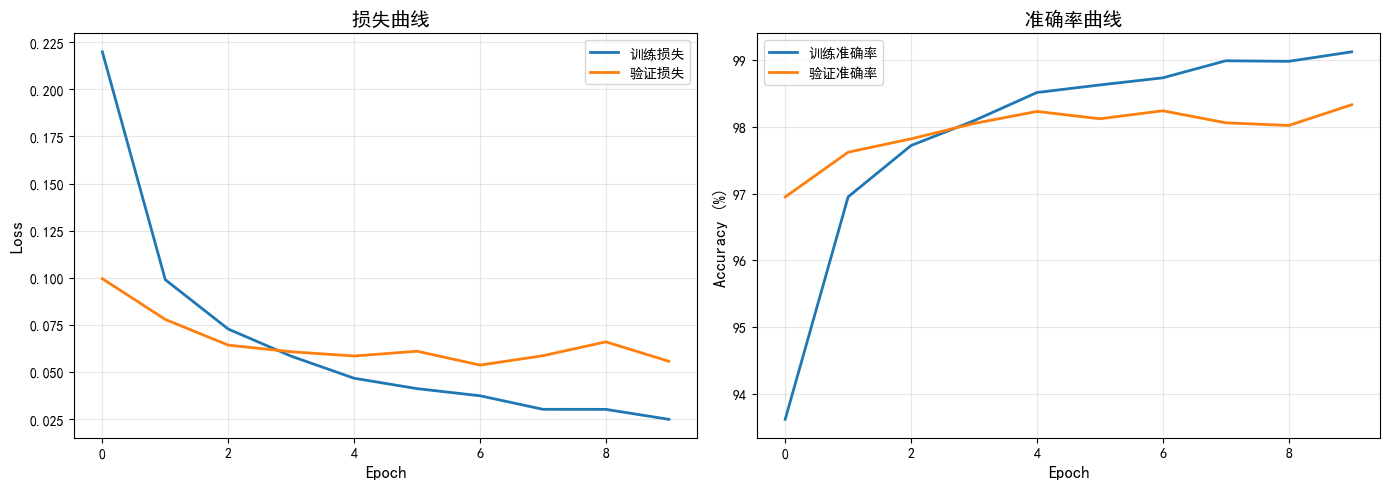

In [10]:
#  7. 可视化训练过程
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 损失曲线
axes[0].plot(history['train_loss'], label='训练损失', linewidth=2)
axes[0].plot(history['val_loss'], label='验证损失', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(' 损失曲线', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 准确率曲线
axes[1].plot(history['train_acc'], label='训练准确率', linewidth=2)
axes[1].plot(history['val_acc'], label='验证准确率', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title(' 准确率曲线', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
#